In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import rankdata
import matplotlib.pyplot as plt

In [2]:
# 파일 리스트 (원하는 파일명으로 바꿔주세요)
file_paths = [
    "kobigbird_925/submit.csv", # 0.907
    "roberta-large_929/roberta-large-aug.csv", # 0.914
    "koelectra_924/result.csv"
]

# 모델별 가중치 (예: AUC 기반 or 신뢰도 기반)
model_aucs = [1, 1, 1]
min_auc = min(model_aucs)
weights = [round((auc - min_auc) * 100) + 1 for auc in model_aucs]
weights = [ i / sum(weights) for i in weights]

# CSV 읽고 열 이름 변경
dfs = [
    pd.read_csv(path).rename(columns={"generated": f"generate_{i}"})
    for i, path in enumerate(file_paths)
]

# ID 기준 병합
merged = dfs[0]
for df in dfs[1:]:
    merged = pd.merge(merged, df, on="ID")

# Soft Voting with Weights
generate_cols = [col for col in merged.columns if col.startswith("generate_")]
weighted_sum = sum(merged[generate_cols[i]] * weights[i] for i in range(len(generate_cols)))
merged["generated"] = weighted_sum

# 결과 저장
final_df = merged[["ID", "generated"]]
final_df.to_csv("./ensemble.csv", index=False)

print("✅ Soft voting with weights 완료!")
print(final_df.head())

✅ Soft voting with weights 완료!
          ID  generated
0  TEST_0000   0.019851
1  TEST_0001   0.999601
2  TEST_0002   0.000233
3  TEST_0003   0.999896
4  TEST_0004   0.999726


In [4]:
# CSV 파일 경로
csv1_path = "./ensemble_933.csv"
csv2_path = "./ensemble.csv"

# 파일 로드
df1 = pd.read_csv(csv1_path).sort_values("ID").reset_index(drop=True)
df2 = pd.read_csv(csv2_path).sort_values("ID").reset_index(drop=True)

# 두 파일 모두 'ID'와 'score' (또는 확률) 컬럼이 있다고 가정
score_col1 = df1.columns[1]  # ex) "prob"
score_col2 = df2.columns[1]

# 각 모델의 score → rank 변환 (0~1로 정규화)
df1["rank1"] = rankdata(df1[score_col1], method="average") / len(df1)
df2["rank2"] = rankdata(df2[score_col2], method="average") / len(df2)

# ID 기준 병합
merged = pd.merge(df1[["ID", "rank1"]], df2[["ID", "rank2"]], on="ID")

# rank 차이 계산
merged["rank_diff"] = (merged["rank1"] - merged["rank2"]).abs()

# 결과 확인
print(merged.head())
print("평균 rank 차이:", merged["rank_diff"].mean())


          ID     rank1     rank2  rank_diff
0  TEST_0000  0.403160  0.400612   0.002548
1  TEST_0001  0.725790  0.725280   0.000510
2  TEST_0002  0.143221  0.144241   0.001019
3  TEST_0003  0.832824  0.830275   0.002548
4  TEST_0004  0.705403  0.743119   0.037717
평균 rank 차이: 0.006797345278954571


In [5]:
# CSV 로드
df1 = pd.read_csv(csv1_path).sort_values("ID").reset_index(drop=True)
df2 = pd.read_csv(csv2_path).sort_values("ID").reset_index(drop=True)

score_col1 = df1.columns[1]  # 확률 값 컬럼
score_col2 = df2.columns[1]

# 순위 변환
df1["rank1"] = rankdata(df1[score_col1], method="average")
df2["rank2"] = rankdata(df2[score_col2], method="average")

# 각 모델의 정렬 순서 → ID 순서 리스트
rank_order1 = df1.sort_values("rank1")["ID"].tolist()
rank_order2 = df2.sort_values("rank2")["ID"].tolist()

# ID → index (순위) 매핑
rank_pos1 = {id_: i for i, id_ in enumerate(rank_order1)}
rank_pos2 = {id_: i for i, id_ in enumerate(rank_order2)}

# 같은 ID에 대해 순위 차 계산
rank_changes = []
for id_ in rank_pos1:
    diff = abs(rank_pos1[id_] - rank_pos2[id_])
    rank_changes.append((id_, rank_pos1[id_], rank_pos2[id_], diff))

# 결과 DataFrame
rank_diff_df = pd.DataFrame(rank_changes, columns=["ID", "rank1", "rank2", "abs_diff"])
rank_diff_df = rank_diff_df.sort_values("abs_diff", ascending=False)


# 상위 변화 큰 샘플 보기
print(rank_diff_df.head(10))


             ID  rank1  rank2  abs_diff
1863  TEST_1713   1863   1675       188
1414  TEST_0891   1414   1601       187
884   TEST_1294    884   1033       149
789   TEST_1564    789    936       147
1026  TEST_1680   1026    883       143
1038  TEST_1129   1038    897       141
1096  TEST_1554   1096   1236       140
898   TEST_0007    898   1038       140
1612  TEST_1102   1612   1752       140
1025  TEST_1049   1025    888       137


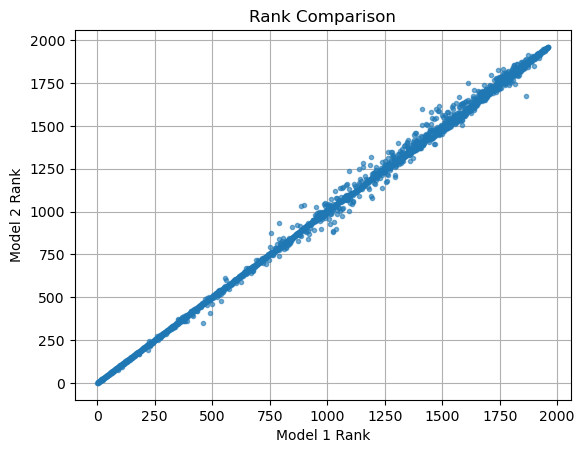

In [6]:
plt.plot(rank_diff_df["rank1"], rank_diff_df["rank2"], '.', alpha=0.6)
plt.xlabel("Model 1 Rank")
plt.ylabel("Model 2 Rank")
plt.title("Rank Comparison")
plt.grid(True)
plt.show()